**ARIMA and LSTM Time Series Models for Google Trends**

This project sought to compare Autoregressive Integrated Moving Average (ARIMA) and Long Short-Term Memory (LSTM) models for various time series data. The general models were used to forecast various trends, including:

S&P 500 historical data
"Olympics" Google Trends

Further, I included results that used gaussian filtering to smooth the original dataset, followed by modeling of the smoothed dataset. The smoothed modeling results were compared to the original series data to determine whether the filtering improved performance of the models.

**Key Findings**

The ARIMA model gave lower root mean squared errors (RMSEs) in 5/7 of the studied time series compared to the LSTM model. In many cases, the models gave similar errors, but on the whole, ARIMA provided higher-quality results, though it struggled to converge on a few series.
Gaussian filtering the dataset prior to creating the model gave lower errors in every case, even when comparing the model results to the original, unfiltered data. On average, the Gaussian filtered predictions reduced the RMSE by close to 100%.
Average RMSEs for unfiltered data, ARIMA: 21.69 & LSTM: 23.54
Average RMSEs for Gaussian filtered data, ARIMA: 10.98 & LSTM: 12.22

**Import Packages**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
import os

Using TensorFlow backend.


**ARIMA Model**

The function below creates an ARIMA model rolling forecast for a given input time series. It allows the user to select p, q, and d values, as well as specify whether to log transform (or not). The various steps in the function include:

log transforming data
creating train/test splits
creating an ARIMA model for the train set
forecasting the first value in the test set, followed by adding that value to the training set and remodeling, forecasting the next value in the test series, adding that second value to the train set, and so on.
inverse transforming the data
creating plots and generating error metrics.
This function will be used below with tuning of the p, d, q, and log transform parameters in order to minimize RMSE values for the out-of-sample data associated with various time series.

In [0]:
import matplotlib.dates as mdates

def arima_model(series, data_split, params, future_periods, log):
    
    # log transformation of data if user selects log as true
    if log == True:
        series_dates = series.index
        series = pd.Series(np.log(series), index=series.index)
       
    # create training and testing data sets based on user split fraction
    size = int(len(series) * data_split)
    train, test = series[0:size], series[size:len(series)]
    history = [val for val in train]

    predictions = []

    # creates a rolling forecast by testing one value from the test set, and then add that test value
    # to the model training, followed by testing the next test value in the series
    for t in range(len(test)):
        model = ARIMA(history, order=(params[0], params[1], params[2]))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        
        yhat = output[0]
        
        predictions.append(yhat[0])
        obs = test[t]
        history.append(obs)
    
    # forecasts future periods past the input testing series based on user input
    future_forecast = model_fit.forecast(future_periods)[0]
   
    future_dates = [test.index[-1]+timedelta(i*365/12) for i in range(1, future_periods+1)]
  
    test_dates = test.index
    
    # if the data was originally log transformed, the inverse transformation is performed
    if log == True:
        predictions = np.exp(predictions)
        test = pd.Series(np.exp(test), index=test_dates)
        future_forecast = np.exp(future_forecast)
    
    # creates pandas series with datetime index for the predictions and forecast values
    forecast = pd.Series(future_forecast, index=future_dates)
    predictions = pd.Series(predictions, index=test_dates)
    
    # generates plots to compare the predictions for out-of-sample data to the actual test values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    myFmt = mdates.DateFormatter('%m%/%y')
    ax.xaxis.set_major_formatter(myFmt)
    plt.plot(predictions, c='red')
    plt.plot(test)
    plt.show()
    
    # calculates root mean squared errors (RMSEs) for the out-of-sample predictions
    error = np.sqrt(mean_squared_error(predictions, test))
    print('Test RMSE: %.3f' % error)
    
    return predictions, test, future_forecast

**S&P 500 ARIMA model**

The ARIMA predictions below have an average RMSE value of 45.5 (with the range of actual values being from ~800 to 2500). One differencing period and log transformation was used.

**LSTM Neural Network Model**

**Creating the datset**

In [0]:
def create_dataset(data_series, look_back, split_frac, transforms):
    
    # log transforming that data, if necessary
    if transforms[0] == True:
        dates = data_series.index
        data_series = pd.Series(np.log(data_series), index=dates)
    
    # differencing data, if necessary
    if transforms[1] == True:
        dates = data_series.index
        data_series = pd.Series(data_series - data_series.shift(1), index=dates).dropna()

    # scaling values between 0 and 1
    dates = data_series.index
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))
    data_series = pd.Series(scaled_data[:, 0], index=dates)
    
    # creating targets and features by shifting values by 'i' number of time periods
    df = pd.DataFrame()
    for i in range(look_back+1):
        label = ''.join(['t-', str(i)])
        df[label] = data_series.shift(i)
    df = df.dropna()
    
    
    # splitting data into train and test sets
    size = int(split_frac*df.shape[0])
    train = df[:size]
    test = df[size:]
    
    # creating target and features for training set
    X_train = train.iloc[:, 1:].values
    y_train = train.iloc[:, 0].values
    train_dates = train.index
    
    # creating target and features for test set
    X_test = test.iloc[:, 1:].values
    y_test = test.iloc[:, 0].values
    test_dates = test.index
    
    # reshaping data into 3 dimensions for modeling with the LSTM neural net
    X_train = np.reshape(X_train, (X_train.shape[0], 1, look_back))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, look_back))
   
    
    return X_train, y_train, X_test, y_test, train_dates, test_dates, scaler

In [0]:
def inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler):
    
    # inverse 0 to 1 scaling
    train_predict = pd.Series(scaler.inverse_transform(train_predict.reshape(-1,1))[:,0], index=train_dates)
    y_train = pd.Series(scaler.inverse_transform(y_train.reshape(-1, 1))[:,0], index=train_dates)

    test_predict = pd.Series(scaler.inverse_transform(test_predict.reshape(-1, 1))[:,0], index=test_dates)
    y_test = pd.Series(scaler.inverse_transform(y_test.reshape(-1, 1))[:,0], index=test_dates)
    
    # reversing differencing if log transformed as well
    if (transforms[1] == True) & (transforms[0] == True):
        train_predict = pd.Series(train_predict + np.log(data_series.shift(1)), index=train_dates).dropna()
        y_train = pd.Series(y_train + np.log(data_series.shift(1)), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + np.log(data_series.shift(1)), index=test_dates).dropna()
        y_test = pd.Series(y_test + np.log(data_series.shift(1)), index=test_dates).dropna()
    
    # reversing differencing if no log transform
    elif transforms[1] == True:
        train_predict = pd.Series(train_predict + data_series.shift(1), index=train_dates).dropna()
        y_train = pd.Series(y_train + data_series.shift(1), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + data_series.shift(1), index=test_dates).dropna()
        y_test = pd.Series(y_test + data_series.shift(1), index=test_dates).dropna()
      
    # reversing log transformation
    if transforms[0] == True:
        train_predict = pd.Series(np.exp(train_predict), index=train_dates)
        y_train = pd.Series(np.exp(y_train), index=train_dates)

        test_predict = pd.Series(np.exp(test_predict), index=test_dates)
        y_test = pd.Series(np.exp(y_test), index=test_dates)
        
    return train_predict, y_train, test_predict, y_test

**LSTM modeling**

Calling the LSTM model below only requires a time series dataset, the number of desired look-back periods, the train/test split, whether to log transform or difference the data, and parameters for training such as number of nodes and epochs. Within the function, it creates the train and test datasets—both features and targets—and then trains an LSTM model, followed by forecasting the out-of-sample data. The predictions from the model, as well as the actual target values are then inverse transformed using the function above, and plots are generated along with error metrics.

In [0]:
def lstm_model(data_series, look_back, split, transforms, lstm_params):
    np.random.seed(1)
    
    # creating the training and testing datasets
    X_train, y_train, X_test, y_test, train_dates, test_dates, scaler = create_dataset(data_series, look_back, split, transforms)
   
    print(X_train)
    
    
    # training the model
    model = Sequential()
    model.add(LSTM(lstm_params[0], input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=lstm_params[1], batch_size=1, verbose=lstm_params[2])
    
    # making predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # inverse transforming results
    train_predict, y_train, test_predict, y_test = \
    inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler)
    
    # plot of predictions and actual values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    myFmt = mdates.DateFormatter('%m%/%y')
    ax.xaxis.set_major_formatter(myFmt)
    plt.plot(y_test)
    plt.plot(test_predict, color='red')
    plt.show()
    
    # calculating RMSE metrics
    error = np.sqrt(mean_squared_error(train_predict, y_train))
    print('Train RMSE: %.3f' % error)
    error = np.sqrt(mean_squared_error(test_predict, y_test))
    print('Test RMSE: %.3f' % error)
    
    return train_predict, y_train, test_predict, y_test

**Gaussian Filter Plotting**

As shown below with the various examples, Gaussian filtering of the data results in better predictions of out-of-sample data. The function below simply allows for a Gaussian-filtered prediction data series to be compared to the original data series through visualization and RMSE reporting.

In [0]:
def gauss_compare(original_series, predictions, data_split):
    
    # the train/test split used to generate the Gaussian-filtered predictions
    size = int(len(original_series)*data_split)

    # creating a plot of the original series and Gaussian-filtered predictions
    fig = plt.figure()
    ax = fig.add_subplot(111)
    myFmt = mdates.DateFormatter('%m%/%y')
    ax.xaxis.set_major_formatter(myFmt)

    plt.plot(original_series[size:])
    plt.plot(predictions, color='red')
    plt.title('Gauss-Filtered Predictions vs. Original Series')
    plt.show()
    
    # calculating the RMSE between the Gaussian-filtered predictions and original dataset. 
    # the +1 exception code is required when differencing is performed, as the earliest data point can be lost
    try:
        error = np.sqrt(mean_squared_error(predictions, original_series[size:]))
    except:
        error = np.sqrt(mean_squared_error(predictions, original_series[size+1:]))
    print('Test RMSE: %.3f' % error)

**Modeling Various Time Series**

The rest of the following code uses the functions above to forecast predictions of various time series. I compared roughly optimized ARIMA models to LSTM models on the unfiltered data for each, as well as with Gaussian filtering.

The optimization was mostly empirical, with some aid coming from autocorrelation and partial autocorrelation plots for ARIMA parameters (code not shown). In general, I optimized p, d, q and log transformation values for ARIMA models, and log/differencing and epochs for LSTM models.

For each example, the plots show the out-of-sample predictions with the actual test values, along with RMSE values. For all plots, the actual (or filtered) time series is traced in BLUE, while the predictions are traced in RED. I tried to choose a variety of trends that included seasonality, steep gradients, increases / decreases over time, etc. Hopefully some of the results are interesting.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


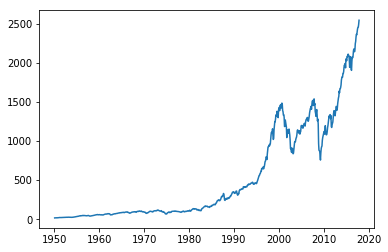

In [5]:

sp500 = pd.read_csv('sphist.csv', parse_dates=['Date'], index_col="Date")
sp500_monthly = sp500.resample('M').mean()
sp500_ts = sp500_monthly.Close
plt.plot(sp500_ts)

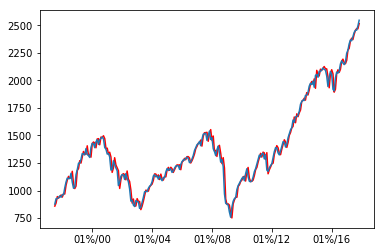

Test RMSE: 45.495


In [0]:
data_split = 0.7
p = 2
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(sp500_ts, data_split, params, future_periods, log)

**S&P 500 LSTM model**

The LSTM model below also uses log transformation and differencing, with 5 training epochs to update model weights. It has a very similar average RMSE error of 46.7.

In [26]:

look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 5
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]



train_predict, y_train, test_predict, y_test = lstm_model(sp500_ts, look_back, split, transforms, lstm_params)



train
[[[0.72217197]]

 [[0.69374613]]

 [[0.75065942]]

 [[0.76278417]]

 [[0.71529402]]

 [[0.44832806]]

 [[0.83920066]]

 [[0.76935057]]

 [[0.78420747]]

 [[0.65867885]]

 [[0.65984071]]

 [[0.87636136]]

 [[0.77267356]]

 [[0.61917383]]

 [[0.70363765]]

 [[0.67482338]]

 [[0.6149124 ]]

 [[0.71962407]]

 [[0.79312208]]

 [[0.74242579]]

 [[0.65313225]]

 [[0.58459103]]

 [[0.75751112]]

 [[0.76114364]]

 [[0.60870097]]

 [[0.68137142]]

 [[0.65807054]]

 [[0.66780451]]

 [[0.7465487 ]]

 [[0.7503794 ]]

 [[0.67966484]]

 [[0.62076287]]

 [[0.60489014]]

 [[0.7595733 ]]

 [[0.78349786]]

 [[0.6834332 ]]

 [[0.63596122]]

 [[0.67834801]]

 [[0.51988239]]

 [[0.68242762]]

 [[0.56144435]]

 [[0.70930306]]

 [[0.67907963]]

 [[0.53002567]]

 [[0.75415399]]

 [[0.73217685]]

 [[0.70646251]]

 [[0.74152293]]

 [[0.73102199]]

 [[0.7292837 ]]

 [[0.78043826]]

 [[0.78398379]]

 [[0.69066049]]

 [[0.78320221]]

 [[0.72568463]]

 [[0.7359645 ]]

 [[0.73410679]]

 [[0.7805892 ]]

 [[0.801

KeyboardInterrupt: ignored

**S&P 500 Gaussian Filtering**

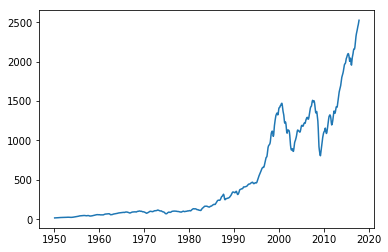

In [0]:

sp500_ts_gauss = pd.Series(gaussian_filter(sp500_ts, sigma=1), index=sp500_ts.index).astype(float)
plt.plot(sp500_ts_gauss)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


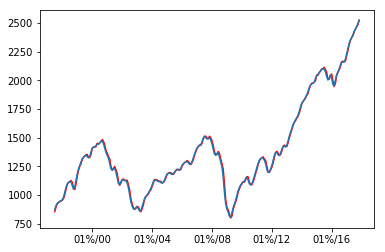

Test RMSE: 15.352


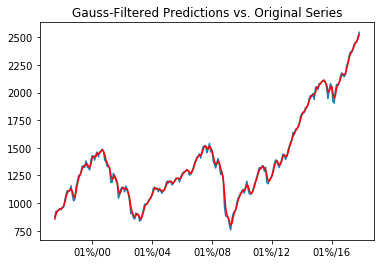

Test RMSE: 24.570


In [0]:

# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(sp500_ts_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussin filter to original series
gauss_compare(sp500_ts, predictions, data_split)

                 t-0       t-1
Date                          
2017-06-30  0.708340  0.700751
2017-07-31  0.692660  0.708340
2017-08-31  0.687289  0.692660
2017-09-30  0.706337  0.687289
2017-10-31  0.701951  0.706337


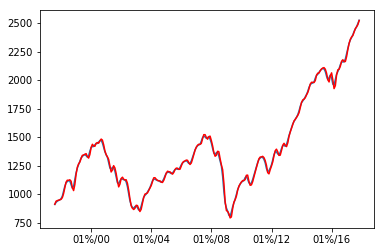

Train RMSE: 2.649
Test RMSE: 16.508


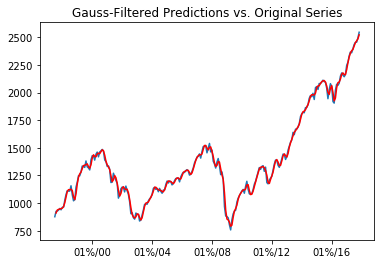

Test RMSE: 24.752


In [0]:

# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 10
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(sp500_ts_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(sp500_ts, test_predict, split)